In [7]:
"""
Environment Setup and Raw Data Ingestion
----------------------------------------
This cell serves as the project's foundation. It configures the Python environment 
for consistent data visualization and loads the raw bank churn records into 
memory for initial auditing.

Key Actions:
1. Import core analytical libraries (Pandas, NumPy, Matplotlib, Seaborn).
2. Configure global visualization parameters for stakeholder-ready plots.
3. Suppress non-critical warnings to ensure a clean report output.
4. Ingest the raw dataset from the project's 'raw' data directory.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1. Pipeline Housekeeping
# We suppress warnings to ensure that the final Jupyter notebook remains clean 
# and readable for non-technical stakeholders, specifically filtering out 
# version-specific deprecation notices.
warnings.filterwarnings('ignore')

# 2. Visual Standardization
# Setting a global theme and palette ensures that all subsequent exploratory 
# data analysis (EDA) adheres to a professional, unified aesthetic.
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

# 3. Data Ingestion: The 'Single Source of Truth'
# We reference the 'raw' directory to ensure that we are always starting 
# from the unmodified customer records.
raw_data_path = '../data/raw/Bank Customer Churn Prediction.csv'

try:
    df = pd.read_csv(raw_data_path)
    
    # Validation Logging
    # Providing immediate feedback on the shape of the dataset confirms that 
    # the ingestion was successful and the volume of data is as expected.
    print(f"--- Data Ingestion Successful ---")
    print(f"Total Customer Records: {df.shape[0]}")
    print(f"Total Attributes:       {df.shape[1]}")
    print("-" * 33)
    
except FileNotFoundError:
    print(f"Critical Error: Dataset not found at {raw_data_path}. Please check directory structure.")

# Initial Data Preview
# Inspecting the head allows for a quick audit of column alignment and data types.
df.head()

--- Data Ingestion Successful ---
Total Customer Records: 10000
Total Attributes:       12
---------------------------------


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
"""
Data Quality Audit and Diagnostic Reporting
------------------------------------------
This cell performs a deep-dive audit of the dataset's integrity. In banking 
analytics, identifying 'silent failures'—such as negative balances or 
excessive zero-values—is critical before proceeding to feature engineering.

Key Actions:
1. Identify Data Types (Dtypes) to ensure features are correctly vectorized.
2. Quantify Missingness (Nulls/Null %) to determine imputation strategies.
3. Audit Cardinality (Uniques) to flag potential identifiers or redundant categories.
4. Detect Numerical Anomalies:
    - Zero Values: Often represent inactive accounts or data entry gaps.
    - Negative Values: Flagged as potential sign-errors in financial extraction.
"""

def professional_audit(df):
    """
    Generates a structured quality report for the provided DataFrame.
    
    This function consolidates various quality metrics into a single 
    view, allowing for immediate identification of data hygiene issues.
    """
    
    # 1. Attribute Inventory
    # We assess the Dtype and Uniques to understand the nature of the data 
    # (Continuous vs. Categorical). High uniqueness in text fields often 
    # requires NLP or removal.
    audit_report = pd.DataFrame({
        'Dtype': df.dtypes,
        'Nulls': df.isnull().sum(),
        'Null %': (df.isnull().sum() / len(df)) * 100,
        'Uniques': df.nunique(),
        
        # 2. Financial Context Audit
        # Zero values in 'balance' or 'salary' are statistically significant 
        # behavioral markers in churn prediction, not necessarily errors.
        'Zero Values': (df == 0).sum(),
        
        # 3. Anomaly Detection
        # Negative values in financial columns (Credit Score, Balance, Salary) 
        # usually indicate systematic extraction errors or sign-flip issues.
        'Negative Values': (df.select_dtypes(include=[np.number]) < 0).sum()
    })
    
    # Fill NaN values in 'Negative Values' for non-numeric columns to maintain report clarity
    audit_report['Negative Values'] = audit_report['Negative Values'].fillna(0).astype(int)
    
    return audit_report

# --- Execution & Reporting ---
# We execute the audit on the raw dataframe to establish a baseline of 'data hygiene'.
audit = professional_audit(df)

print("--- DATA QUALITY AUDIT REPORT ---")
print(f"Scope: {len(df.columns)} Features | {len(df)} Observations")
print("Status: Diagnostic complete. Results pending review.")
print("-" * 33)

# Utilizing 'display' for an interactive, formatted table in the Jupyter environment
display(audit)

--- DATA QUALITY AUDIT REPORT ---
Scope: 12 Features | 10000 Observations
Status: Diagnostic complete. Results pending review.
---------------------------------


,Dtype,Nulls,Null %,Uniques,Zero Values,Negative Values
active_member,int64,0,0.0,2,4849,0
age,int64,0,0.0,70,0,0
balance,float64,0,0.0,6382,3617,0
churn,int64,0,0.0,2,7963,0
country,object,0,0.0,3,0,0
credit_card,int64,0,0.0,2,2945,0
credit_score,int64,0,0.0,460,0,0
customer_id,int64,0,0.0,10000,0,0
estimated_salary,float64,0,0.0,9999,0,0
gender,object,0,0.0,2,0,0


In [9]:
"""
Categorical Integrity Audit and String Standardization
-----------------------------------------------------
This cell examines the 'String Health' of categorical variables. In enterprise 
databases, manual entry or legacy migrations often introduce 'Dirty Data' 
(e.g., 'France ' vs. 'france'), which can artificially inflate cardinality 
and degrade model performance.

Key Actions:
1. Catalog unique values for all categorical and binary attributes.
2. Implement a 'String Audit' to detect hidden whitespace and casing issues.
3. Validate categorical consistency across the primary features.
"""

# 1. Scope Definition for Qualitative Analysis
# We include binary flags (Credit Card, Active Member) as they are 
# mathematically categorical in nature.
cat_cols = ['country', 'gender', 'products_number', 'credit_card', 'active_member', 'churn']

print("--- Categorical Diversity Audit ---")
for col in cat_cols:
    # We display unique values to ensure labels are within expected ranges 
    # (e.g., binary columns should only contain {0, 1}).
    unique_vals = df[col].unique()
    print(f"Attribute: {col:15} | Unique Values: {unique_vals}")

# 2. String Normalization Audit (Defensive Programming)
# We create a temporary normalized series to check if hidden inconsistencies exist.
# Strip() removes trailing/leading spaces; lower() handles case-sensitivity.
country_audit_series = df['country'].str.strip().str.lower()

# 3. Conflict Detection Logic
# If the unique count of the raw column differs from the normalized version, 
# it indicates that 'France' and 'france ' are being treated as separate entities.
if df['country'].nunique() != country_audit_series.nunique():
    print("\n[ALERT] Structural Inconsistency Detected: Casing or whitespace issues identified.")
    print(f"Raw Unique Count: {df['country'].nunique()} | Standardized Count: {country_audit_series.nunique()}")
else:
    print("\n[SUCCESS] Categorical Consistency Validated: No 'Dirty' string variations detected.")

# Cleanup of audit artifacts
if 'country_audit' in df.columns:
    df.drop(columns=['country_audit'], inplace=True)

--- Categorical Diversity Audit ---
Attribute: country         | Unique Values: ['France' 'Spain' 'Germany']
Attribute: gender          | Unique Values: ['Female' 'Male']
Attribute: products_number | Unique Values: [1 3 2 4]
Attribute: credit_card     | Unique Values: [1 0]
Attribute: active_member   | Unique Values: [1 0]
Attribute: churn           | Unique Values: [1 0]

[SUCCESS] Categorical Consistency Validated: No 'Dirty' string variations detected.


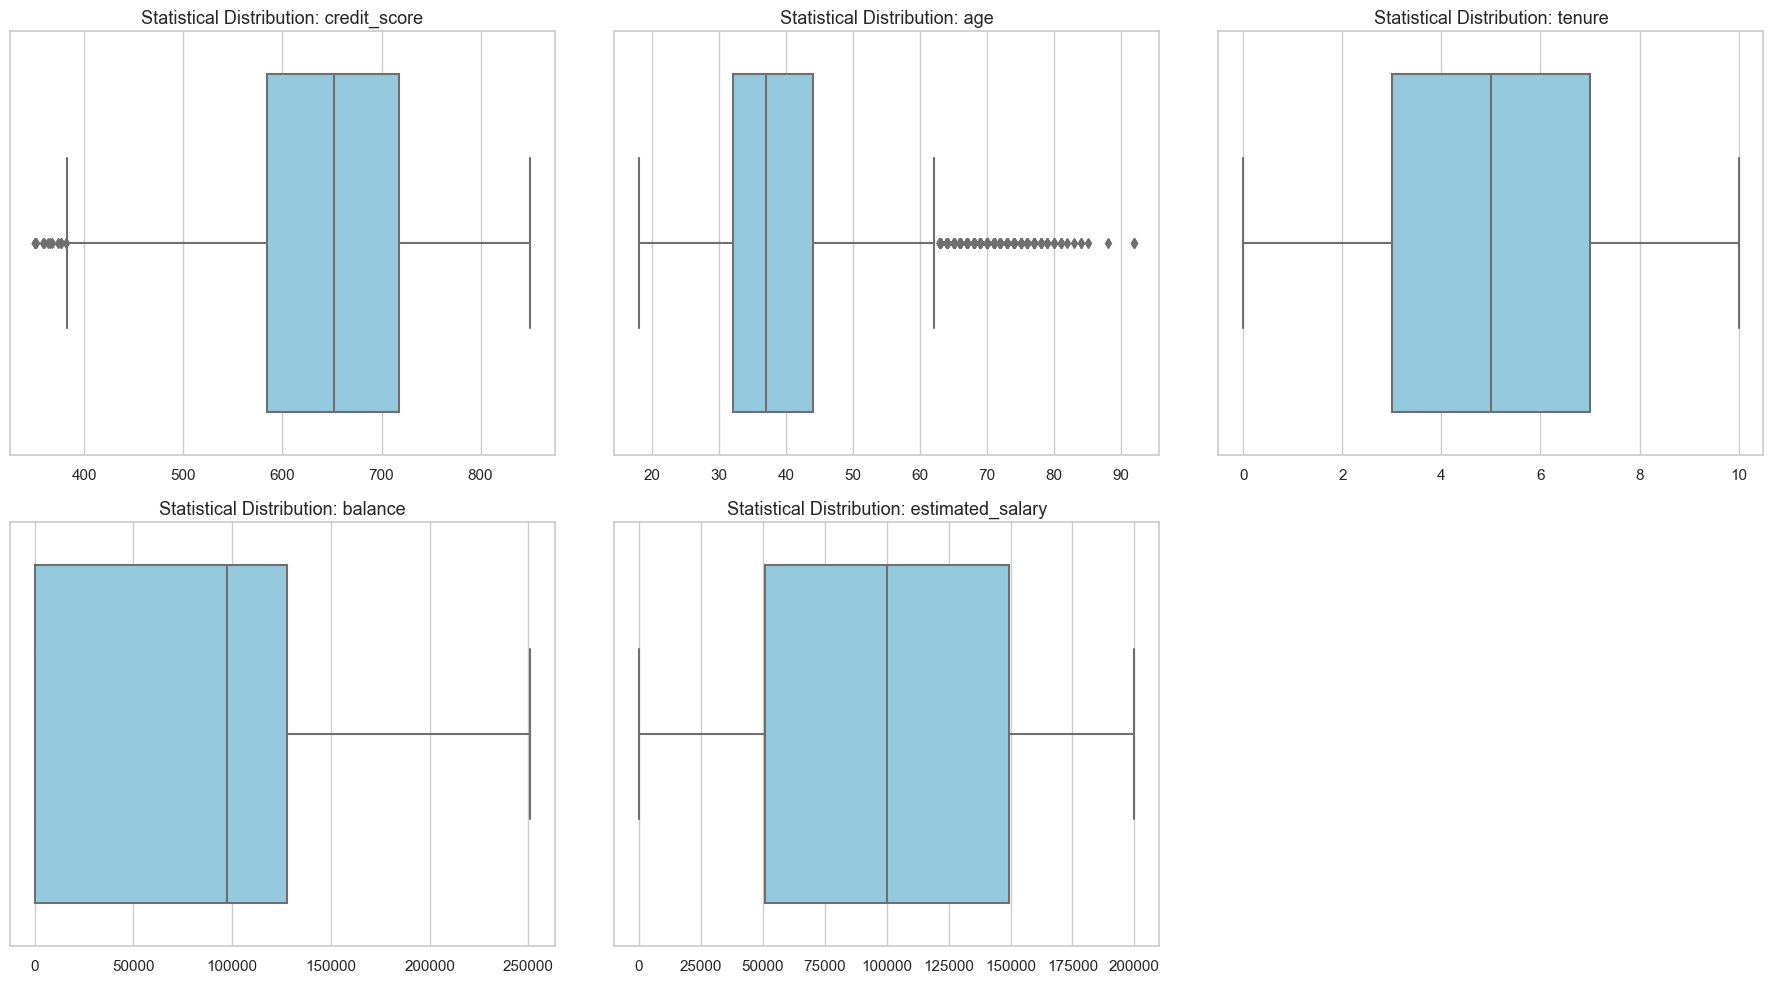

In [10]:
"""
Numerical Outlier Detection and Distribution Analysis
-----------------------------------------------------
This cell utilizes boxplots to perform a univariate analysis of the 
dataset's continuous variables. In banking models, outliers (e.g., 
unusually high balances or credit scores) can significantly impact 
distance-based algorithms and linear estimators.

Key Actions:
1. Define the scope of numerical attributes for statistical review.
2. Initialize a multi-plot figure to visualize distributions in parallel.
3. Generate boxplots to identify the Interquartile Range (IQR) and 
   statistical outliers (points beyond 1.5 * IQR).
"""

# 1. Target Attribute Selection
# We focus on financial metrics (Credit Score, Balance, Salary) and 
# demographics (Age, Tenure) to understand the range of our customer profiles.
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

# 2. Visualization Grid Configuration
# We use a 2x3 grid to display all five features. Note: One axis will 
# remain empty as we have an odd number of features.
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 3. Iterative Distribution Mapping
for i, col in enumerate(num_cols):
    # Boxplots are the industry standard for identifying 'Skewness' and 'Outliers'.
    # The 'Whiskers' represent the reach of the data, while the dots beyond 
    # them represent extreme observations.
    sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
    
    # Professional labeling for technical clarity
    axes[i].set_title(f'Statistical Distribution: {col}', fontsize=13)
    axes[i].set_xlabel('') # Removing redundant x-labels for a cleaner aesthetic

# 4. Final Layout Refinement
# Tight layout prevents axis overlap, ensuring the report is presentation-ready.
plt.tight_layout()

# Removing the unused 6th axis to maintain structural symmetry in the notebook
if len(num_cols) < len(axes):
    axes[-1].set_visible(False)

plt.show()

--- Target Variable Audit ---
Retained (0): 79.63%
Exited   (1): 20.37%
------------------------------


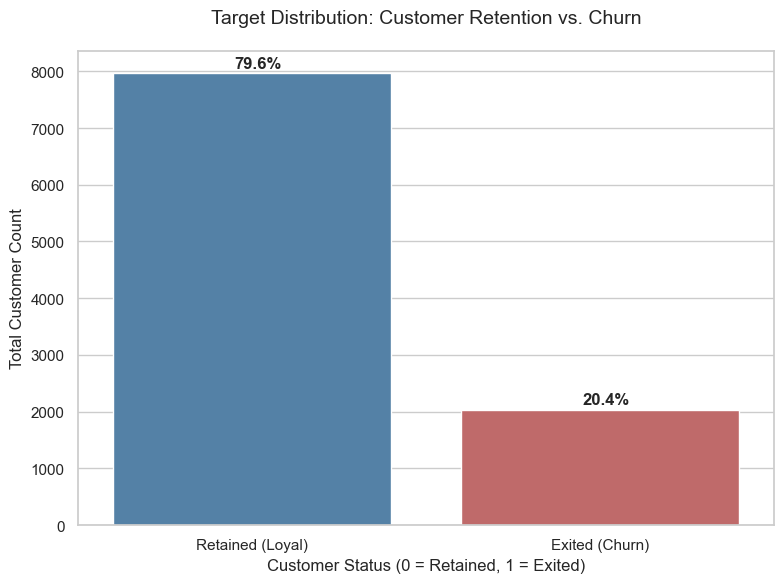

In [11]:
"""
Target Class Distribution and Imbalance Audit
---------------------------------------------
This cell analyzes the 'Churn' label to determine the balance between positive 
(Exited) and negative (Retained) classes. In predictive modeling for banking, 
imbalance is a critical factor that influences metric selection (e.g., opting 
for F1-Score or ROC-AUC over simple Accuracy).

Key Actions:
1. Calculate the percentage distribution of churn vs. retained customers.
2. Visualize the frequency of each class using a standardized countplot.
3. Annotate the visualization with percentage labels for immediate business insight.
"""

# 1. Statistical Imbalance Calculation
# We normalize the value counts to obtain the proportional split. 
# A ~20% churn rate is standard for the banking industry but qualifies as 
# 'Class Imbalance' for machine learning purposes.
churn_counts = df['churn'].value_counts(normalize=True) * 100

print("--- Target Variable Audit ---")
print(f"Retained (0): {churn_counts[0]:.2f}%")
print(f"Exited   (1): {churn_counts[1]:.2f}%")
print("-" * 30)

# 2. Visual Representation of Class Balance
# We use a countplot to illustrate the volume difference between classes.
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='churn', palette=['#4682B4', '#CD5C5C'])

# 3. Dynamic Annotation Logic
# Professional dashboards include direct value/percentage labels to avoid 
# ambiguity for executive stakeholders.
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + (total * 0.01)
    ax.annotate(percentage, (x, y), fontsize=12, fontweight='bold')

plt.title('Target Distribution: Customer Retention vs. Churn', fontsize=14, pad=20)
plt.xlabel('Customer Status (0 = Retained, 1 = Exited)', fontsize=12)
plt.ylabel('Total Customer Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Retained (Loyal)', 'Exited (Churn)'])

plt.tight_layout()
plt.show()

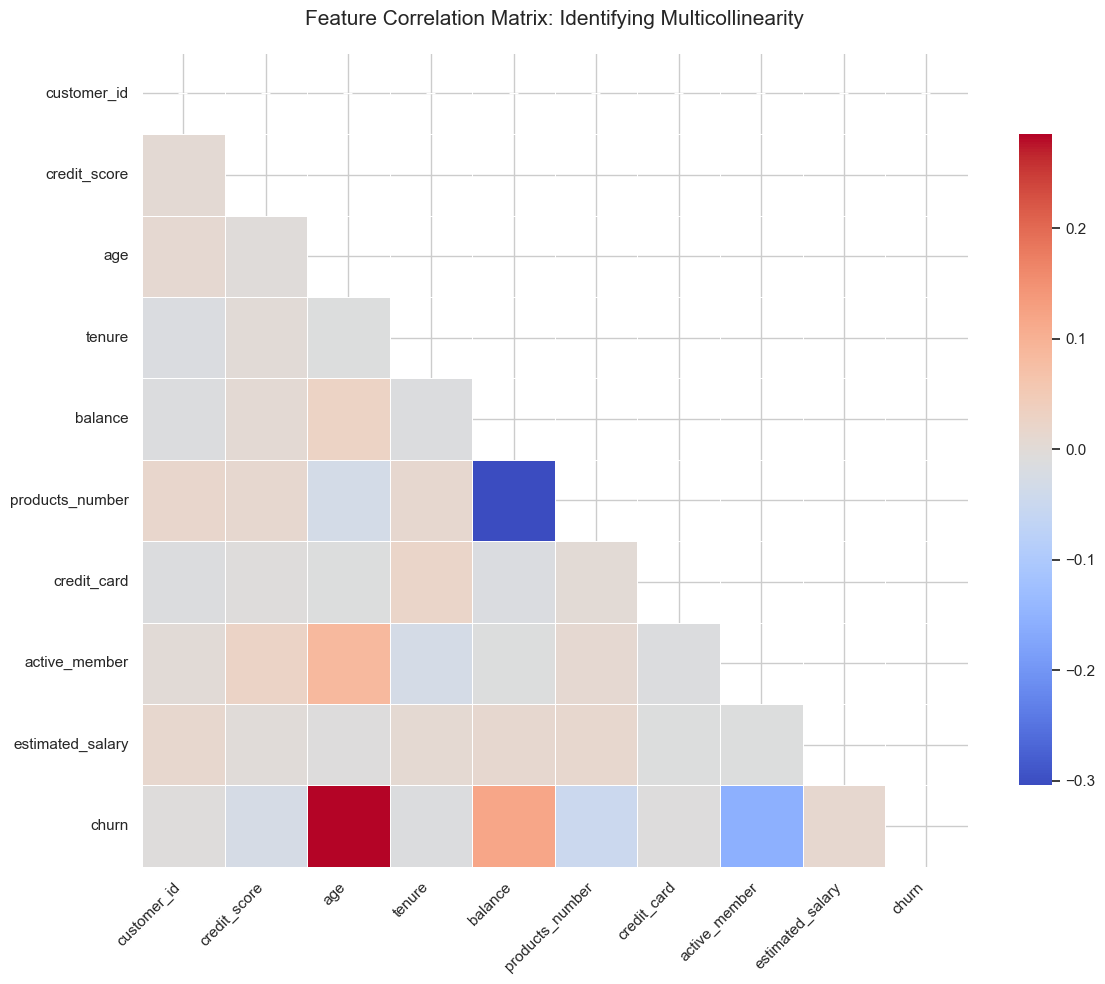

In [12]:
"""
Feature Correlation Matrix and Multicollinearity Audit
------------------------------------------------------
This cell generates a comprehensive heatmap of the Pearson Correlation 
Coefficients. This is a critical step in the 'Top-Level' pipeline to ensure 
that redundant features (highly correlated pairs) do not destabilize the 
model coefficients or inflate feature importance.

Key Actions:
1. Isolate numerical attributes to ensure mathematical consistency.
2. Compute the Pearson Correlation Matrix.
3. Implement a 'Triangle Mask' to remove redundant mirrored data, 
   improving visual clarity for executive review.
4. Visualize the matrix using a diverging color palette (coolwarm).
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Statistical Matrix Computation
# We isolate numeric types to avoid computation errors. The resulting matrix 
# values range from -1 (perfect inverse correlation) to +1 (perfect correlation).
# Note: Values near 0 indicate no linear relationship.
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# 2. Visual Optimization: Triangle Masking
# In a correlation matrix, the top-right and bottom-left triangles are identical. 
# We mask the upper triangle to focus the stakeholder's eye on unique relationships.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 3. High-Fidelity Heatmap Generation
plt.figure(figsize=(12, 10))

# 'coolwarm' is the industry standard for heatmaps: 
# Red = Positive Correlation | Blue = Negative Correlation.
sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5,
    cbar_kws={"shrink": .8} # Scaling the color bar for a balanced UI
)

# 4. Professional Labeling
plt.title('Feature Correlation Matrix: Identifying Multicollinearity', fontsize=15, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()